In [117]:
#!pip install darts statsmodels prophet

In [118]:
#pip install --upgrade torch
#779MB

IMPORT LIBRARY

In [119]:
# Compiler: Google Colab 100%

from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import time
t_start1 = time.perf_counter()

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

import warnings
warnings.filterwarnings("ignore")


MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default 5 %

# Dataset downloaded from https://www.kaggle.com/code/nageshsingh/predict-electricity-consumption/input

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOAD DATASET**

In [121]:
# Load Dataset
elec = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kelas Work/Project/Case Study 3/Electric_Production.csv')
elec

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


**DATA EXPLORATION**

In [122]:
#Mengetahui nama-nama kolom pada Dataset
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [123]:
# Mengubah datatype DATE dari object menjadi datetime
elec['DATE'] = pd.to_datetime(elec['DATE'])
elec.dtypes

DATE     datetime64[ns]
Value           float64
dtype: object

In [124]:
elec.isna().sum() # Memeriksa berapa banyak nilai NaN pada Dataset

DATE     0
Value    0
dtype: int64

In [125]:
# Rename 'DATE' to 'date' (lowercase)
elec.rename(columns={'DATE': 'date'}, inplace = True)

# Rename 'Value' to 'value' (lowercase)
elec.rename(columns={'Value': 'value'}, inplace = True)

elec

,date,value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [126]:
elec = elec.set_index(elec.date) # set date menjadi acuan
elec.drop('date', axis = 1, inplace = True) # drop kolom date untuk mencegah duplikasi kolom date
print('Column datatypes= \n',elec.dtypes)
elec

Column datatypes= 
 value    float64
dtype: object


,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


**TIMESERIES TREND ANALYSIS**

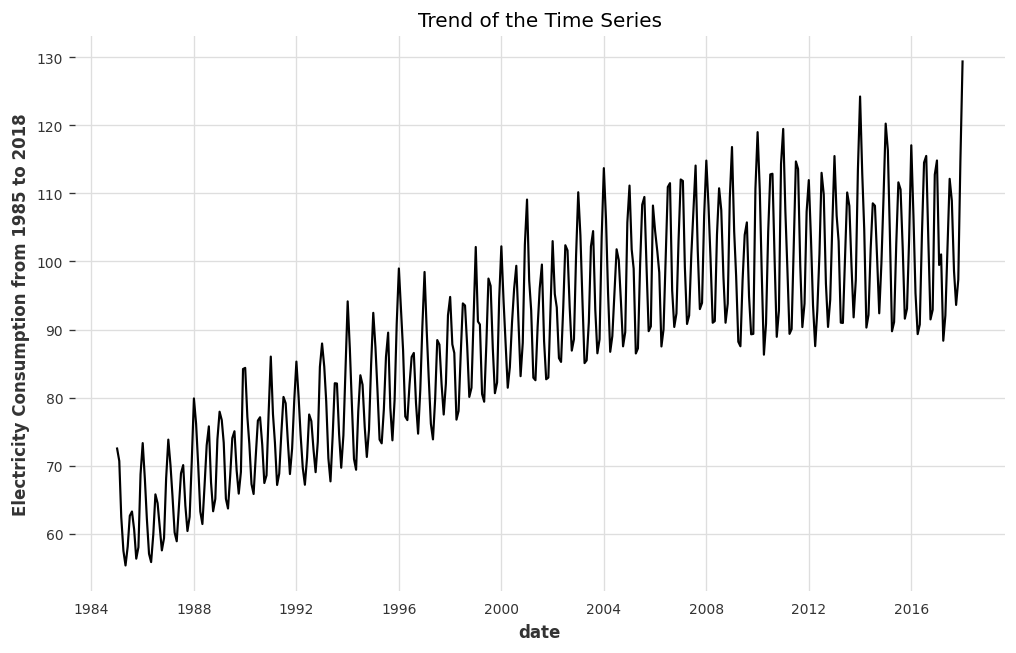

In [127]:
# Plot trend dari timeseries
plt.figure(figsize= (10,6))
plt.plot(elec)
plt.xlabel('date')
plt.ylabel('Electricity Consumption from 1985 to 2018')
plt.title('Trend of the Time Series')
plt.show()

**PLOT SEASONALITY TIMESERIES**

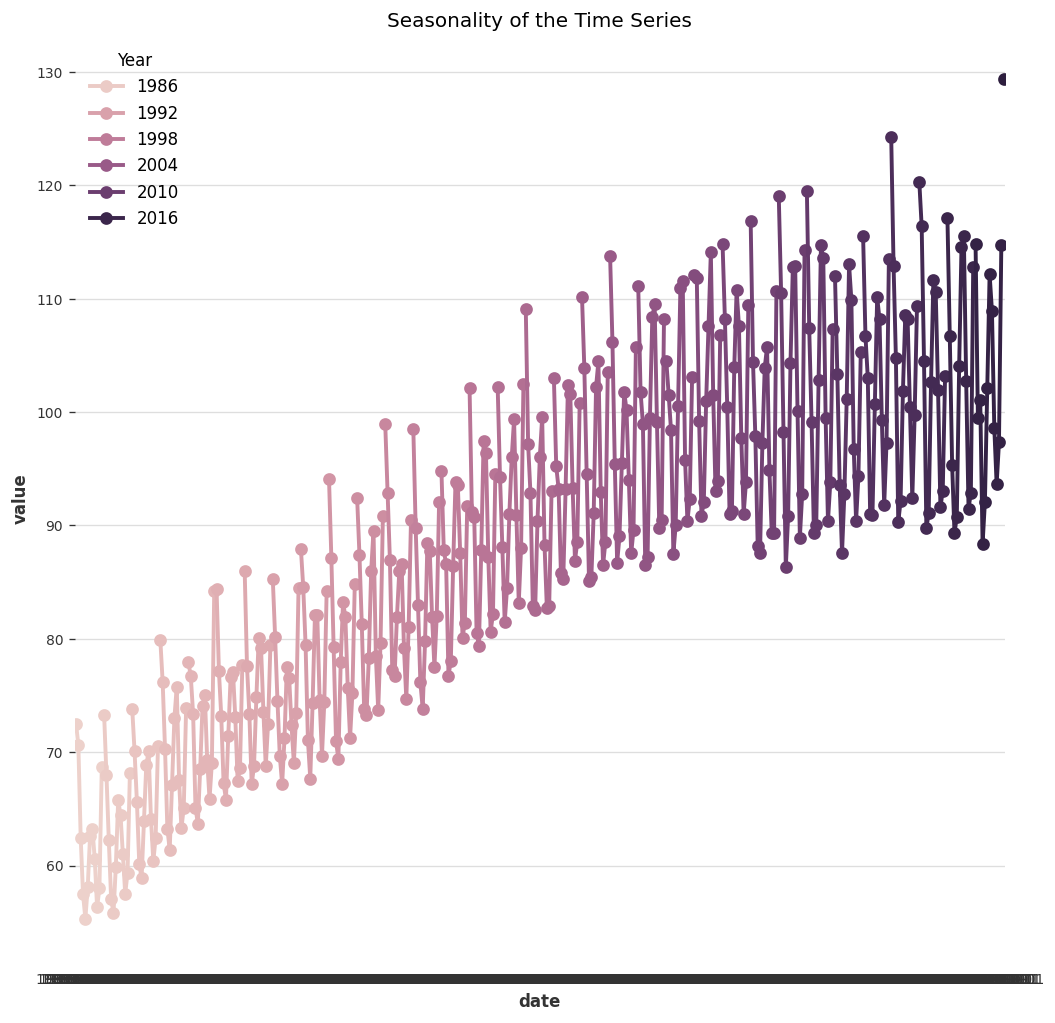

In [128]:
# Plot seasonality dari Time Series
elec_temp = elec.copy()
elec_temp['Year'] = pd.DatetimeIndex(elec_temp.index).year
elec_temp['Month'] = pd.DatetimeIndex(elec_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='date',y='value',hue='Year',data=elec_temp)
plt.show()

In [129]:
elec_ts = elec.reset_index() #reset format dataframe
elec_ts

,date,value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


**ANALISIS CHECK SEASONALITY**

In [130]:
# Analisa pattern seasonality, autocorrelation, dan potensi residual

from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts import TimeSeries
ts = TimeSeries.from_dataframe(elec_ts, time_col = 'date', value_cols = 'value')
series = ts #buat backup

In [131]:
series

<TimeSeries (DataArray) (date: 397, component: 1, sample: 1)>
array([[[ 72.5052]],

       [[ 70.672 ]],

       [[ 62.4502]],

       [[ 57.4714]],

       [[ 55.3151]],

       [[ 58.0904]],

       [[ 62.6202]],

       [[ 63.2485]],

       [[ 60.5846]],

       [[ 56.3154]],

...

       [[ 88.353 ]],

       [[ 92.0805]],

       [[102.1532]],

       [[112.1538]],

       [[108.9312]],

       [[ 98.6154]],

       [[ 93.6137]],

       [[ 97.3359]],

       [[114.7212]],

       [[129.4048]]])
Coordinates:
  * date       (date) datetime64[ns] 1985-01-01 1985-02-01 ... 2018-01-01
  * component  (component) object 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [132]:
# cek seasonality
for m in range(2, 50):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA)
    if is_seasonal == True:
        print('Seasonality Detected! Seasonal period = ', m)
        break

Seasonality Detected! Seasonal period =  6


**DECOMPOSE TIMESERIES**

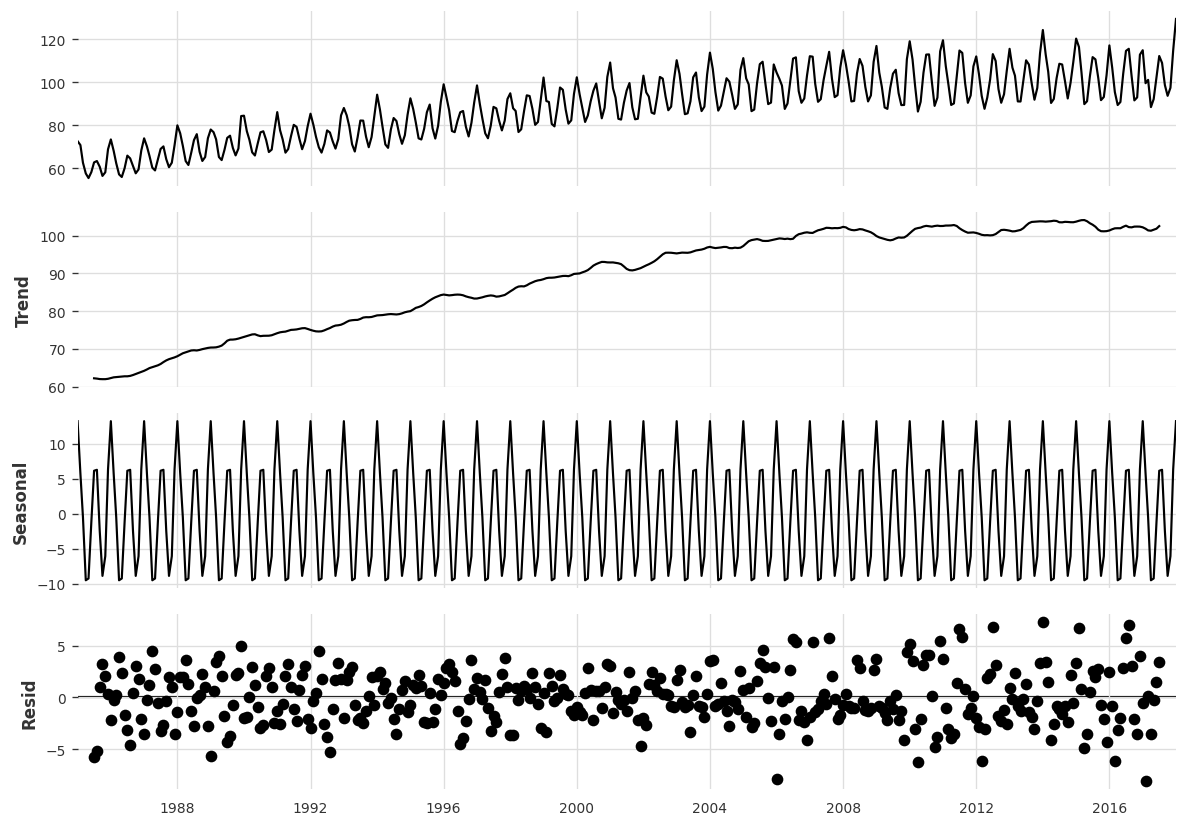

In [133]:
elec_additive = sm.tsa.seasonal_decompose(elec, model='additive') # decompose secara additive
fig = elec_additive.plot()

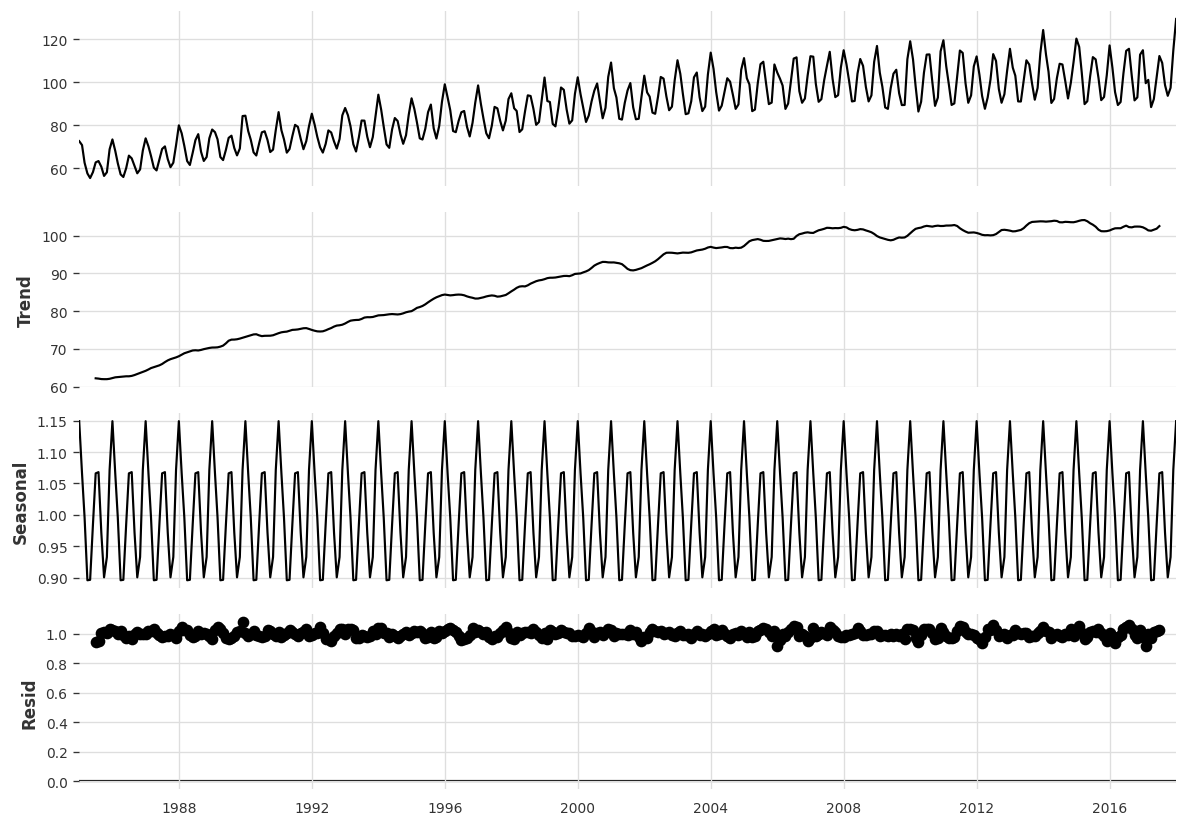

In [134]:
elec_multiplicative = sm.tsa.seasonal_decompose(elec, model='multiplicative') # decompose secara multiplicative
fig = elec_multiplicative.plot()

Karakteristik dari data ini adalah Multiplikatif, karena pada bagian residual, grafik menunjukkan pola yang dapat diklasifikasi sebagai pola horizontal/konstan

**TIMESERIES ANALYSIS**

In [135]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()

    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('Electricity Consumption Value')
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')
    plt.legend()
    plt.show()

    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

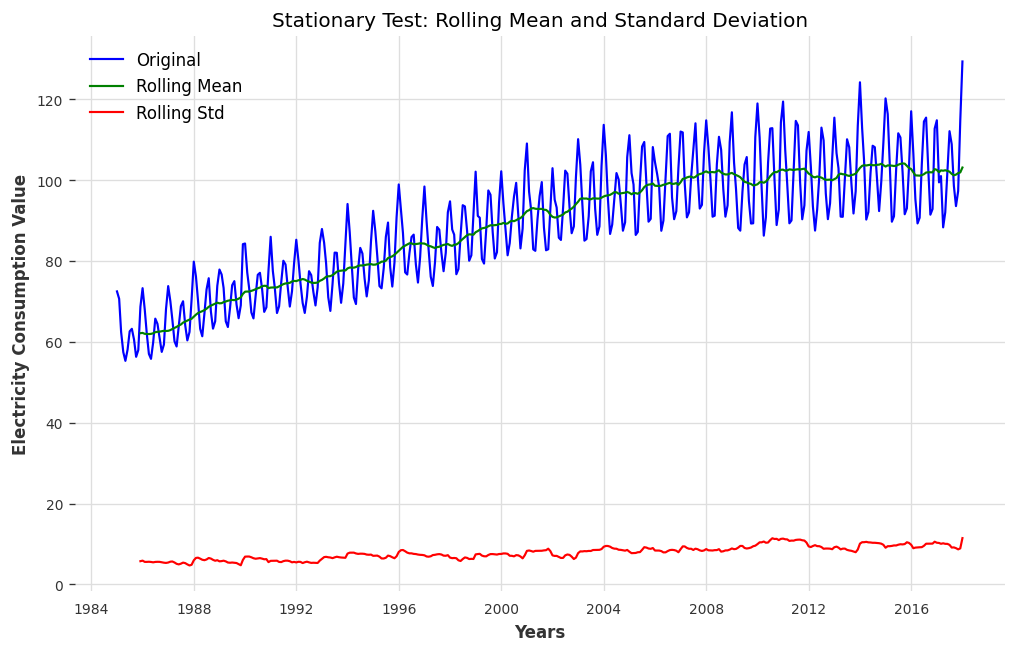

Results of Dickey-Fuller Test
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [136]:
# tes stationarity dari original series data
stationarity_test(elec)

Analisa:
Dengan test stationarity ini, dapat disimpulkan bahwa data ini bukan data stationer, karena:
1. p-value bernilai tinggi yaitu 0.186215, jauh diatas 0.05
2. Rolling mean dan Rolling std tidak berpola horizontal/konstan

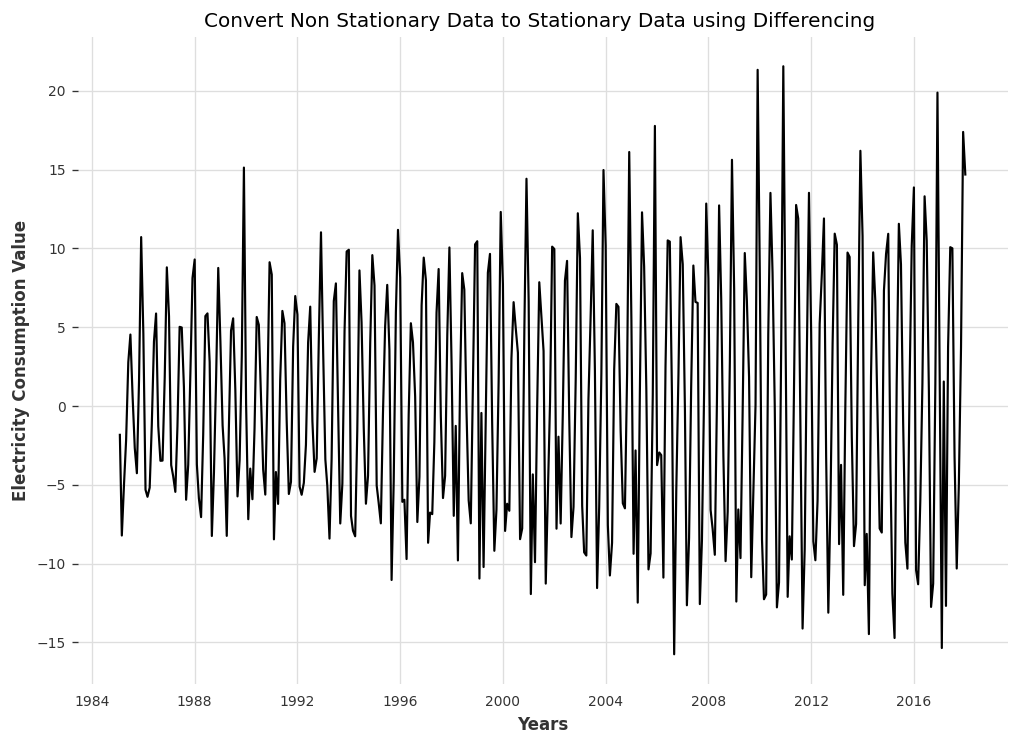

In [137]:
elec_diff1 = elec.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Electricity Consumption Value')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(elec_diff1)

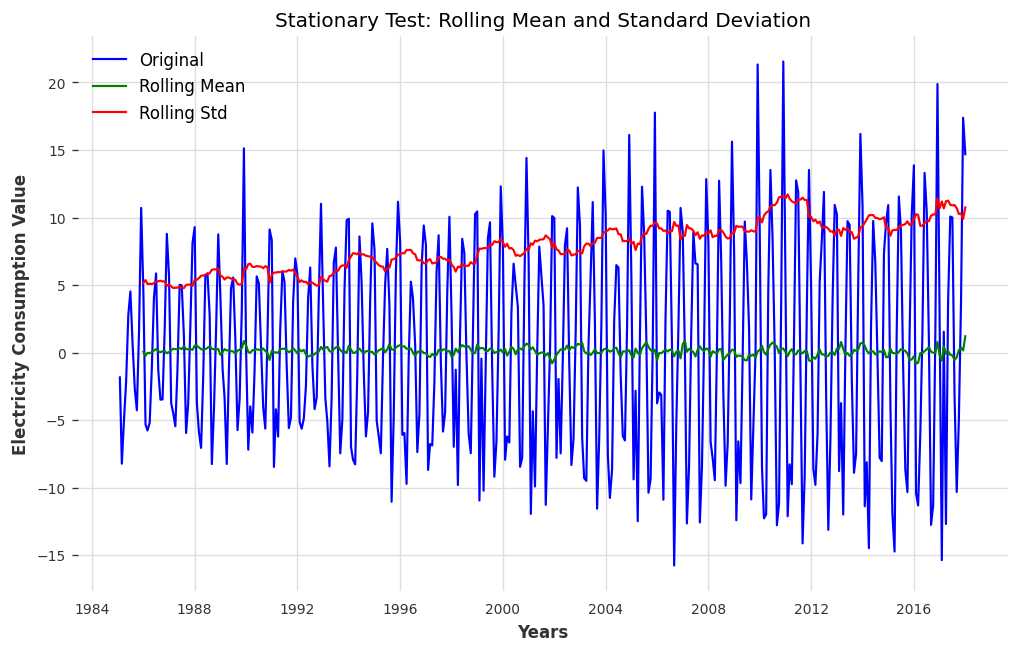

Results of Dickey-Fuller Test
Test Statistic                -7.104891e+00
p-value                        4.077787e-10
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [138]:
elec_diff1.dropna(inplace = True)# Data transformation may add na values
stationarity_test(elec_diff1)

Analisa: Setelah dilakukan metode differencing dan Dickey-Fuller Test, maka dapat disimpulkan bahwa data telah bersifat stationarity dengan pertimbangan sebagai berikut:

nilai Test Statistics sangat rendah hingga mencapai angka negatif, merupakan salah satu bukti yang kuat untuk membuktikan data stationarity
p-value bernilai sangat rendah yaitu p-value 4.077787e-10

Sebenarnya, data ini sudah dapat diolah ke tahap selanjutnya yaitu, Test/Train dan forecasting dengan ARIMA. Namun, ketika dilakukan forecasting dengan memproses data elec_diff1, maka evaluasi yang dihasilkan adalah:

RMSE: 3.5420625495279467
R2: 0.860805213423459
MAPE: 116.13091017787931
Fitting the time series model takes 95.7530665397644 seconds.
<Axes: xlabel='date'>

RMSE: 3.5420625495279467, cukup rendah, berarti sudah dapat menggambarkan keseluruhan trend dengan baik.
R2: 0.860805213423459 berarti ada korelasi positif 86.08% antara actual dan predicted.
MAPE: 116.13091017787931, cukup tinggi sehingga mungkin terjadi ketidakakuratan pada forecasting.

oleh karena itu, diputuskan untuk melakukan log-transform kepada dataset untuk menaikkan sifat stationarity pada data.


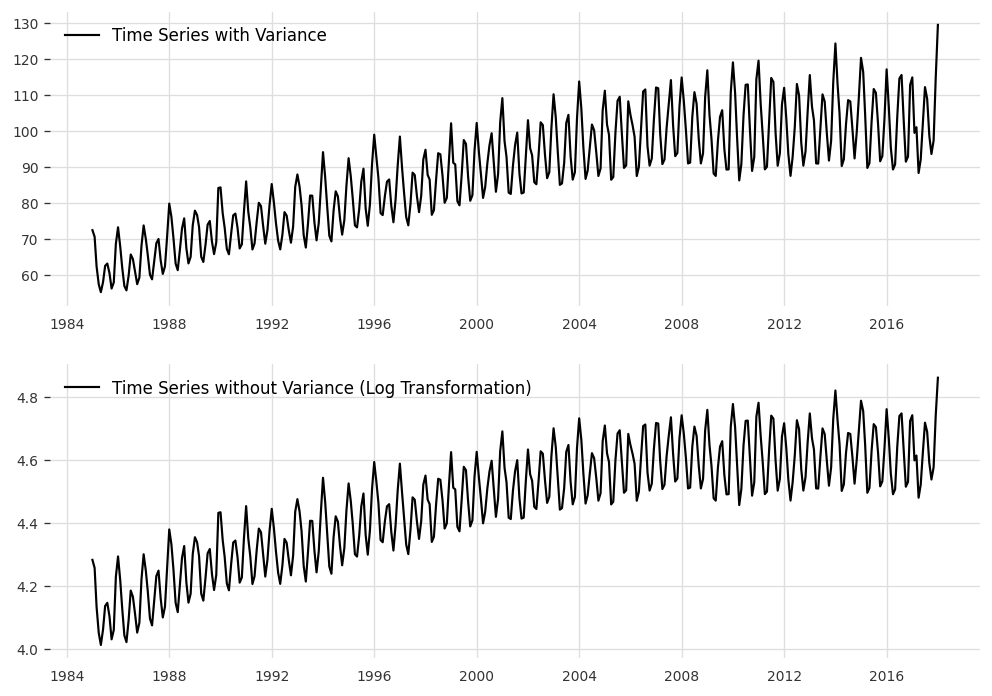

In [139]:
elec_log = np.log(elec) # log-transform untuk mengeliminasi variance pada data

plt.subplot(211)
plt.plot(elec, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(elec_log, label='Time Series without Variance (Log Transformation)')
plt.legend()
plt.show()

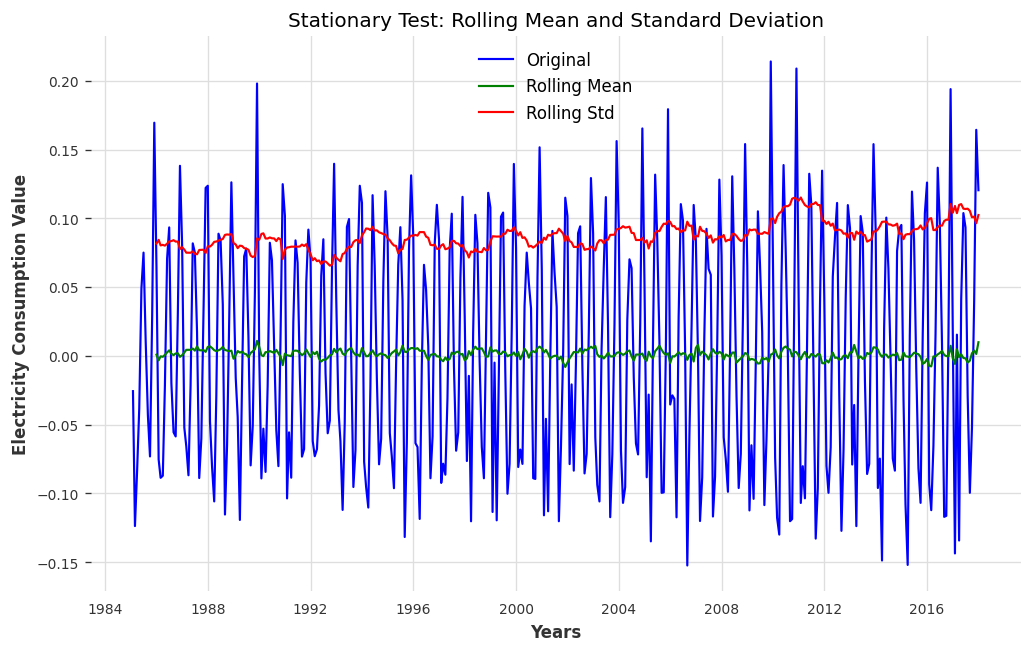

Results of Dickey-Fuller Test
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [140]:
elec_log_diff1 = elec_log.diff(periods = 1) # First order differencing kepada parameter elec_log

elec_log_diff1.dropna(inplace = True)# Data transformation may add na values
stationarity_test(elec_log_diff1)

In [141]:
elec_log_diff1 # Memastikan kembali isi dari data elec_ciff1 yaitu dataset yang telah dimodifikasi dan menjalani metode differencing

,value
date,
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242
1985-06-01,0.048954
...,...
2017-09-01,-0.099489
2017-10-01,-0.052051
2017-11-01,0.038991


In [142]:
elec_ts = elec_log_diff1.reset_index() # mereset kembali data set menjadi bentuk dataframe semula
elec_ts

,date,value
0,1985-02-01,-0.025609
1,1985-03-01,-0.123680
2,1985-04-01,-0.083082
3,1985-05-01,-0.038242
4,1985-06-01,0.048954
...,...,...
391,2017-09-01,-0.099489
392,2017-10-01,-0.052051
393,2017-11-01,0.038991
394,2017-12-01,0.164337


In [143]:
# membuat array yang berisi date dan value
ts = TimeSeries.from_dataframe(elec_ts, time_col = 'date', value_cols = 'value')
series = ts # (untuk backup)
ts

<TimeSeries (DataArray) (date: 396, component: 1, sample: 1)>
array([[[-0.02560883]],

       [[-0.12368002]],

       [[-0.08308201]],

       [[-0.03824151]],

       [[ 0.04895449]],

       [[ 0.07508749]],

       [[ 0.0099835 ]],

       [[-0.04303068]],

       [[-0.0730727 ]],

       [[ 0.0294836 ]],

...

       [[-0.13417237]],

       [[ 0.04132304]],

       [[ 0.10381045]],

       [[ 0.0933975 ]],

       [[-0.02915465]],

       [[-0.09948905]],

       [[-0.0520507 ]],

       [[ 0.03899114]],

       [[ 0.16433695]],

       [[ 0.12044064]]])
Coordinates:
  * date       (date) datetime64[ns] 1985-02-01 1985-03-01 ... 2018-01-01
  * component  (component) object 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 1.0, 'Grafik ts Dataset ')

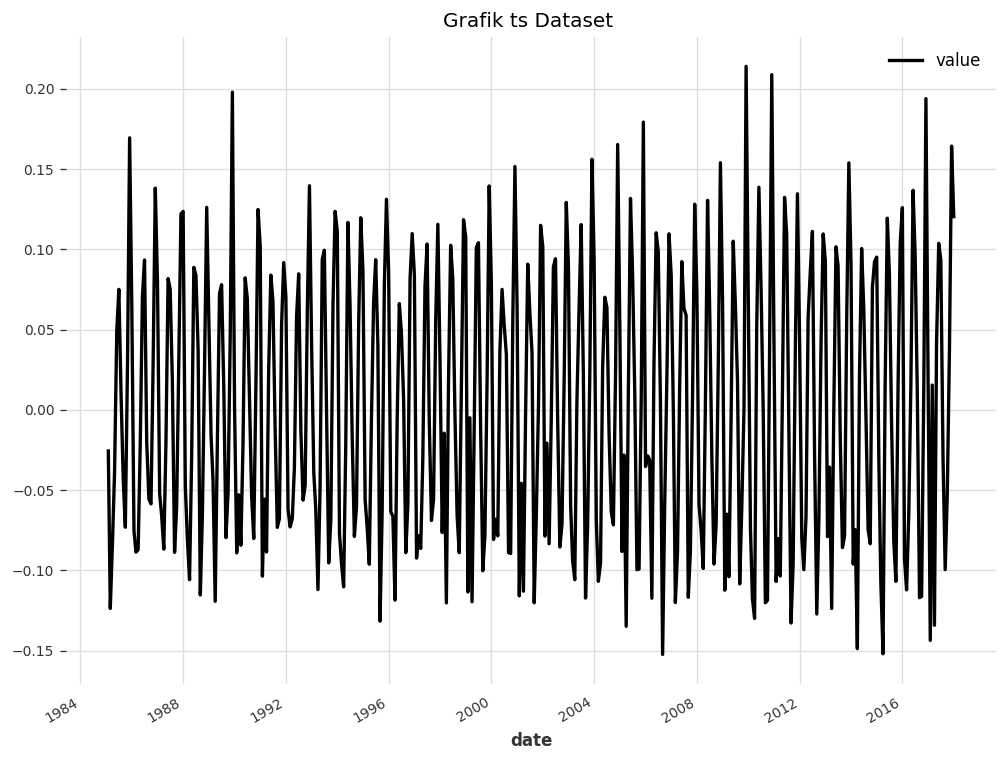

In [144]:
ts.plot() # plot grafik dari ts yang berisi dataset elec yang telah diubah menjadi array
plt.title('Grafik ts Dataset ')

**TRAIN / TEST SPLIT**

Text(0.5, 1.0, 'Train / Test Data Split ')

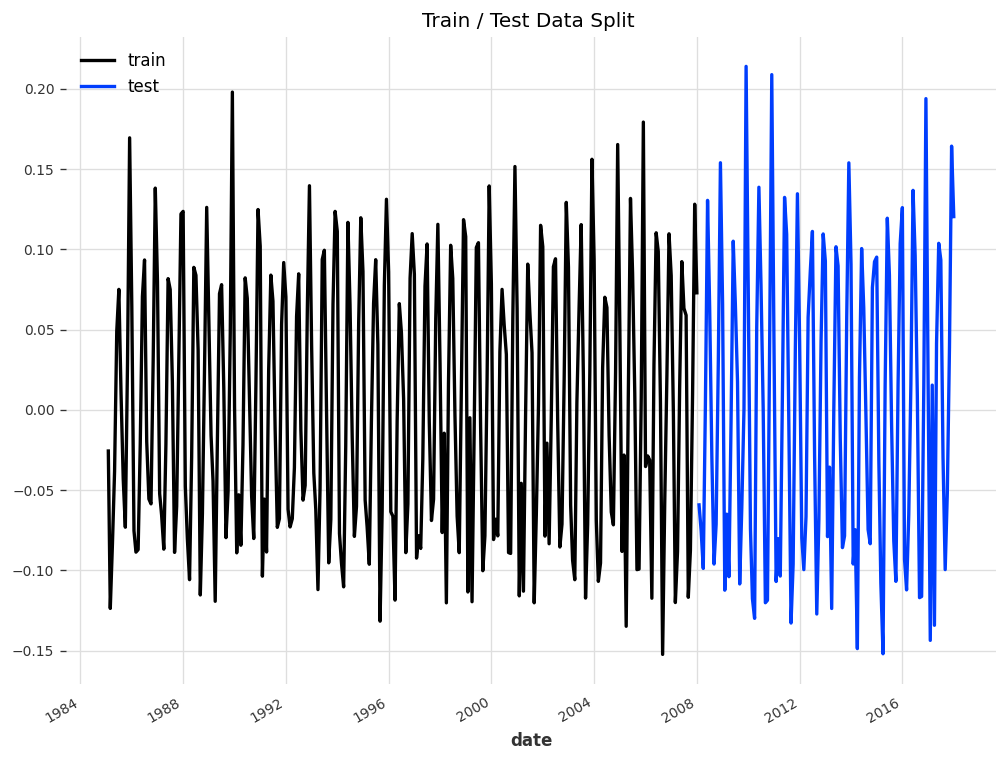

In [145]:
ts_train, ts_test = ts.split_before(0.70) # datatrain 70%, datatest 30%
ts_train.plot(label = 'train')
ts_test.plot(label = 'test')
plt.title('Train / Test Data Split ')

In [146]:
#function bernama evaluate untuk mengevaluasi prediksi dibanding data actual
def evaluate(actual_test, prediction):
    print(f'RMSE: {rmse(actual_test, prediction)}')
    print(f'R2: {r2_score(actual_test, prediction)}')
    print(f'MAPE: {mape(actual_test, prediction)}')

AutoARIMA Default Setting

RMSE: 0.06119727122777704
R2: 0.56714155323211
MAPE: 92.13420945911045
Fitting the time series model takes 26.585672855377197 seconds.


Text(0.5, 1.0, 'Train Model TimeSeries dengan AutoARIMA Default Setting ')

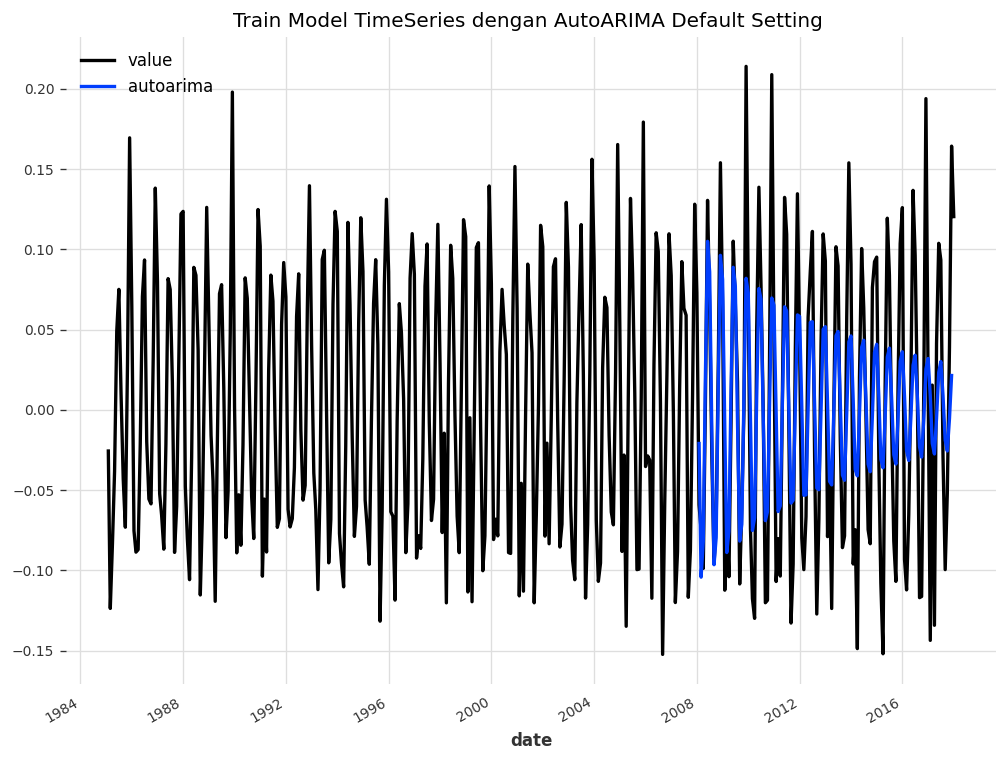

In [147]:
autoarima = AutoARIMA() #settingan default
start = time.time()
autoarima.fit(ts_train)
end = time.time()
autoarima_forecast = autoarima.predict(119) #angka 119 merupakan 30% data dari 396 baris

#evaluasi menggunakan evaluate
evaluate(ts_test, autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
autoarima_forecast.plot(label = 'autoarima')
plt.title('Train Model TimeSeries dengan AutoARIMA Default Setting ')

Dengan menggunakan AutoARIMA setting default, pattern yang dihasilkan tidak sesuai dengan pola data actual. Selain itu, R2 bernilai 0.56714155323211, atau dengan kata lain, terdapat akurasi 56.7% dari variasi dalam data aktual. Meskipun mungkin tergolong moderat, hasil ini dapat ditingkatkan.

In [148]:
from pmdarima import arima

new_autoarima = AutoARIMA(d=1, # berapa kali nge-differencing biar jadi seasonal, pada bahasan differencing diatas : df_log_diff = df_log.diff(periods = 1) # First order differencing
                          max_d=1,
                          D=1, # periode differencing harus berapa periode seasonality
                          m=6, # periode seasonality. nilai ini diperoleh dari cek seasonality is_seasonal
                          seasonal=True, # kita kasi tau kalo time series kita seasonal
                          max_order=10, # semakin tinggi angka ini, maka semakin banyak parameter pula yang dicari
                          stationary=True, # kita kasi tau kalo time series kita nggak stationary (False) kalo stationary maka True
                          suppress_warnings=False) # biar pas dia fitting modelnya ga banyak keluar output

RMSE: 0.03140607467231813
R2: 0.8859988848341923
MAPE: 102.81014545273969
Fitting the time series model takes 92.89873933792114 seconds.


Text(0.5, 1.0, ' Train Model TimeSeries dengan NewAutoARIMA ')

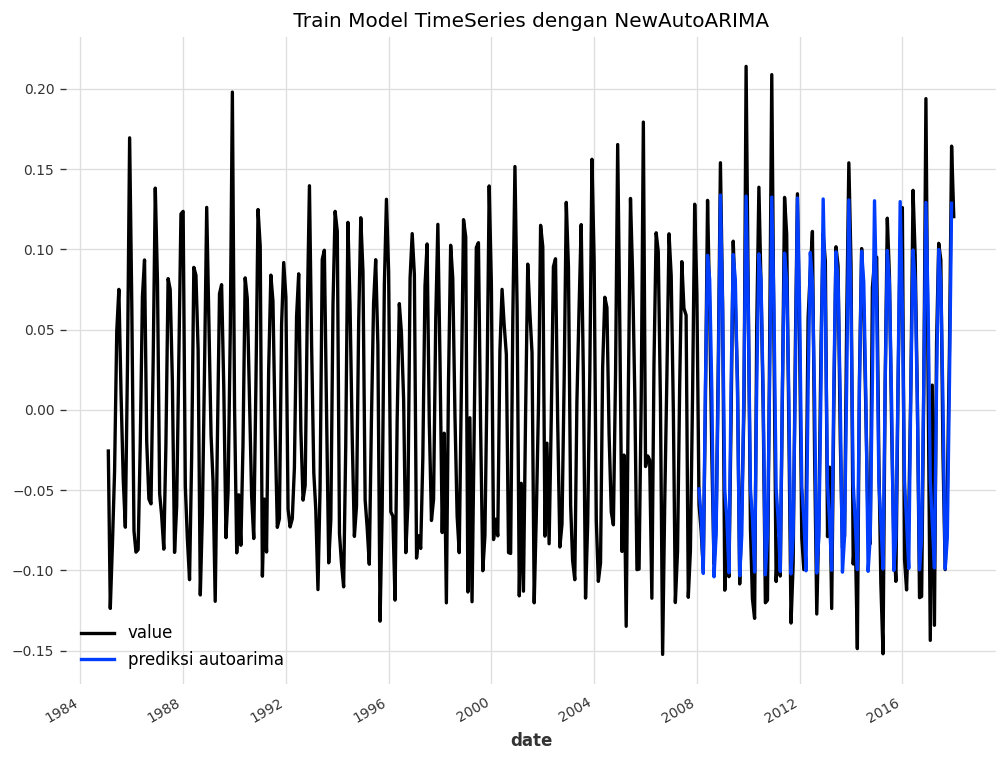

In [149]:
start = time.time()
new_autoarima.fit(ts_train) #fitting untuk mempelajari ts_train atau proses training
end = time.time()

new_autoarima_forecast = new_autoarima.predict(119) #prediksi pada 119 baris dataset masa depan (30% dari 396 baris di dataset Electricity Consumption)
evaluate(ts_test, new_autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
new_autoarima_forecast.plot(label = 'prediksi autoarima')
plt.title(' Train Model TimeSeries dengan NewAutoARIMA ')

Dengan menggunakan new-AutoARIMA, model prediksi sudah cukup sesuai dengan aktual.

nilai RMSE sangat rendah, mendekati 0, berarti nilai prediksi sangat mendekati nilai aktual

nilai R2 cukup tinggi, yaitu 0.8859988848341923, artinya, 88,59% mendekati data aktual

In [150]:
#reverse ts array to dataframe
predict_data = new_autoarima_forecast.pd_dataframe()
predict_data = predict_data.rename(columns={'value': 'prediction value'}) # rename kolom value menjadi prediction value
predict_data

component,prediction value
date,
2008-02-01,-0.049227
2008-03-01,-0.066220
2008-04-01,-0.101867
2008-05-01,0.014179
2008-06-01,0.096322
...,...
2017-08-01,0.003813
2017-09-01,-0.099036
2017-10-01,-0.079781


In [151]:
#reverse ts array to dataframe
ts_test_data = ts_test.pd_dataframe()
ts_test_data

component,value
date,
2008-02-01,-0.059172
2008-03-01,-0.074761
2008-04-01,-0.098749
2008-05-01,0.002638
2008-06-01,0.130552
...,...
2017-09-01,-0.099489
2017-10-01,-0.052051
2017-11-01,0.038991


In [152]:
df_predictions =pd.DataFrame(predict_data, columns=['prediction value']) # nama kolom 'prediction value' harus sama seperti yang diatas
pd.concat([ts_test_data,df_predictions],axis =1).T

date,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,...,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01
value,-0.059172,-0.074761,-0.098749,0.002638,0.130552,0.063406,-0.029284,-0.096020,-0.071252,0.030389,...,-0.134172,0.041323,0.103810,0.093397,-0.029155,-0.099489,-0.052051,0.038991,0.164337,0.120441
prediction value,-0.049227,-0.066220,-0.101867,0.014179,0.096322,0.081393,0.010841,-0.103959,-0.077562,0.018200,...,-0.098422,0.014551,0.099977,0.078792,0.003813,-0.099036,-0.079781,0.017630,0.128738,NaN


**FUTURE PREDICTIONS**

In [153]:
future_prediction = new_autoarima.predict(131)

Text(0.5, 1.0, 'Future Prediction TimeSeries')

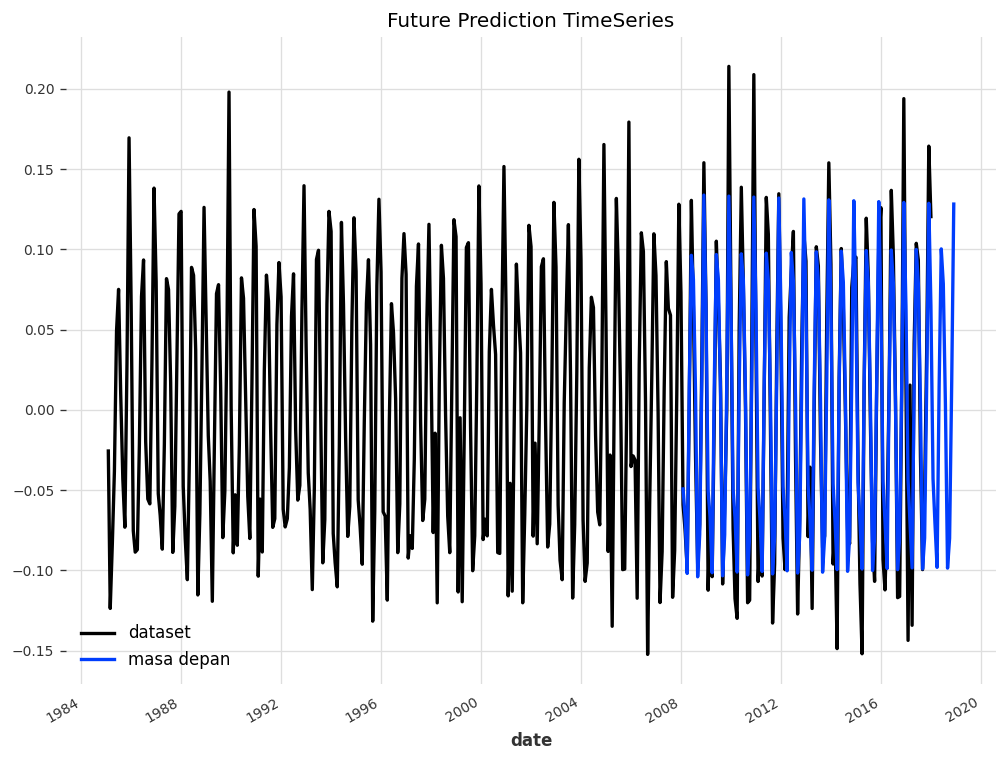

In [154]:
ts.plot(label = 'dataset')
future_prediction.plot(label='masa depan')
plt.title('Future Prediction TimeSeries')